In [1]:
# vvod = pd.read_csv('data/ввод_в_оборот.csv')
# move = pd.read_csv('data/перемещение_товаров.csv')
# sales = pd.read_csv(
#     'data/выход_товаров.csv',
#     dtype={'price': np.uint32, 'cnt': np.uint32},
#     parse_dates=['dt']
# )

# vvod.to_parquet('data/vvod.parquet')
# move.to_parquet('data/move.parquet')
# sales.to_parquet('data/sales.parquet')

In [4]:
def preprocess():
    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    from sklearn.preprocessing import LabelEncoder
    import matplotlib.pyplot as plt
    import pickle

    vvod = pd.read_parquet('dataset/input.parquet')
    move = pd.read_parquet('dataset/transition.parquet')
    sales = pd.read_parquet('dataset/output.parquet')
    production = pd.read_csv('dataset/Справочник продукции.csv')
    tochki = pd.read_csv('dataset/Справочник торговых точек.csv')
    participants = pd.read_csv('dataset/Справочник участников оборота товаров.csv')

    # Выкидываем самые маленькие города
    a = tochki.city_with_type.value_counts()
    a = a[a >= 3].index
    tochki = tochki[tochki.city_with_type.isin(a)]


    label_enc_d = {}

    label_enc_d['id_sp'] = LabelEncoder().fit(tochki.id_sp_.unique().tolist()+sales.id_sp_.unique().tolist())
    tochki['id_sp_'] = label_enc_d['id_sp'].transform(tochki.id_sp_).astype(np.uint16)
    sales['id_sp_'] = label_enc_d['id_sp'].transform(sales.id_sp_).astype(np.uint16)

    label_enc_d['inn'] = LabelEncoder().fit(tochki.inn.unique().tolist()+participants.inn.unique().tolist()+sales.inn.unique().tolist()+\
                                            sales.prid.unique().tolist()+vvod_inn_unique+move.receiver_inn.unique().tolist()+\
                                            move.sender_inn.unique().tolist()+move.prid.unique().tolist()+production.inn.unique().tolist())
    participants['inn'] = label_enc_d['inn'].transform(participants.inn).astype(np.uint16)
    tochki['inn'] = label_enc_d['inn'].transform(tochki.inn).astype(np.uint16)

    vvod['inn'] = label_enc_d['inn'].transform(vvod.inn).astype(np.uint16)
    vvod['prid'] = label_enc_d['inn'].transform(vvod.prid).astype(np.uint16)
    vvod_inn_unique = vvod.inn.unique().tolist()
    vvod['prid'] = label_enc_d['inn'].transform(vvod.prid).astype(np.uint16)
    vvod['gtin'] = label_enc_d['gtin'].transform(vvod.gtin).astype(np.uint32)
    vvod_gtin_unique = vvod.gtin.unique().tolist()

    label_enc_d['gtin'] = LabelEncoder().fit(vvod_gtin_unique+sales.gtin.unique().tolist()+\
                                            move.gtin.unique().tolist()+production.gtin.unique().tolist())
    del(vvod)



    move['prid'] = label_enc_d['inn'].transform(move.prid).astype(np.uint16)
    move['sender_inn'] = label_enc_d['inn'].transform(move.sender_inn).astype(np.uint16)
    move['receiver_inn'] = label_enc_d['inn'].transform(move.receiver_inn).astype(np.uint16)



   
    
    sales['inn'] = label_enc_d['inn'].transform(sales.inn).astype(np.uint16)
    sales['prid'] = label_enc_d['inn'].transform(sales.prid).astype(np.uint16)
  
    
    production['inn'] = label_enc_d['inn'].transform(production.inn).astype(np.uint16)

 
    sales['gtin'] = label_enc_d['gtin'].transform(sales.gtin)
    
    move['gtin'] = label_enc_d['gtin'].transform(move.gtin).astype(np.uint32)
    production['gtin'] = label_enc_d['gtin'].transform(production.gtin).astype(np.uint32)

    label_enc_d['product_short_name'] = LabelEncoder().fit(production.product_short_name.unique().tolist())
    production['product_short_name'] = label_enc_d['product_short_name'].transform(production.product_short_name).astype(np.uint8)

    label_enc_d['product_name'] = LabelEncoder().fit(production.product_name.unique().tolist())
    production['product_name'] = label_enc_d['product_name'].transform(production.product_name).astype(np.int32)

    label_enc_d['tnved'] = LabelEncoder().fit(production.tnved.unique().tolist())
    production['tnved'] = label_enc_d['tnved'].transform(production.tnved)

    label_enc_d['tnved10'] = LabelEncoder().fit(production.tnved10.unique().tolist())
    production['tnved10'] = label_enc_d['tnved10'].transform(production.tnved10).astype(np.uint8)

    label_enc_d['brand'] = LabelEncoder().fit(production.brand.unique().tolist())
    production['brand'] = label_enc_d['brand'].transform(production.brand)

    label_enc_d['city'] = LabelEncoder().fit(tochki.city_with_type.unique())
    tochki['city_with_type'] = label_enc_d['city'].transform(tochki.city_with_type).astype(np.uint16)

    sales['month'] = sales.dt.dt.month.astype(np.int8)
    sales['year'] = sales.dt.dt.year.astype(np.int16)
    sales['num_month'] = (sales.year - 2021) * 12 + sales.month
    sales['num_week'] = (sales.year - 2021) * 12 * 5 + sales.dt.dt.isocalendar().week

    tochki['region_code'] = tochki.region_code.astype(np.uint8)

    sales = sales.merge(tochki[['id_sp_', 'region_code', 'city_with_type']], how='left', on='id_sp_')
    sales = sales.merge(production[['gtin', 'product_short_name', 'product_name']], how='left', on='gtin')

    sales['region_code'] = sales['region_code'].fillna(-1).astype(np.int8)
    sales['product_name'] = sales['product_name'].fillna(-1).astype(np.int32)
    sales['product_short_name'] = sales['product_short_name'].fillna(-1).astype(np.int16)

    a = sales.groupby('product_short_name')['cnt'].sum()
    a = a[a > 500].index
    sales = sales[(sales.product_short_name.isin(a))&(sales['city_with_type'].notna())]

    sales['city_with_type'] = sales['city_with_type'].astype(np.int16)

    sales = sales[(sales.type_operation == 'Продажа конечному потребителю в точке продаж')&(sales.product_name!=-1)&(sales.region_code!=-1)]

    sales = sales.reset_index(drop=True).drop(['gtin', 'prid', 'id_sp_', 'type_operation', 'dt'], axis=1)
    sales.to_parquet('data/sales_preproc.parquet')
    pickle.dump(label_enc_d, open('data/label_enc_d.pkl', 'wb'))
preprocess()

UnboundLocalError: local variable 'vvod_inn_unique' referenced before assignment

100%|██████████| 1/1 [00:00<00:00, 31.49it/s]


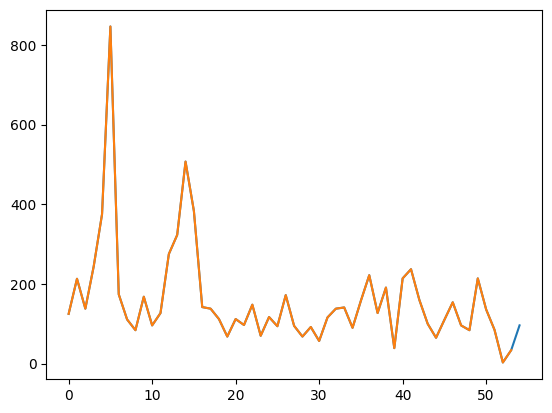

In [23]:
def inference(inn):
    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    from sklearn.preprocessing import LabelEncoder
    import matplotlib.pyplot as plt
    import pickle

    sales = pd.read_parquet('data/sales_preproc.parquet')
    label_enc_d = pickle.load(open('data/label_enc_d.pkl', 'rb'))

    MAIN_D_price = {}
    MAIN_D_cnt = {}

    cur_sales = sales[(sales.inn==label_enc_d['inn'].transform([inn])[0])]

    for region in tqdm(cur_sales.city_with_type.unique()):
        cur_sales = cur_sales[cur_sales.city_with_type==region][['num_month', 'product_short_name', 'inn', 'price', 'cnt', 'num_week']]

        cur_sales['comb'] = cur_sales['num_week'].astype('str') + '__' + cur_sales['product_short_name'].astype('str') + '__' + cur_sales.inn.astype('str')

        cnt, price, comb = cur_sales.cnt.tolist(), cur_sales.price.tolist(), cur_sales.comb.tolist()
        cur_d = {x: [0,0] for x in cur_sales.comb.unique()}
        for x, cur_comb in enumerate(comb):
            cur_d[cur_comb][0] += price[x] * cnt[x]
            cur_d[cur_comb][1] += cnt[x]

        month, name, inn = [], [], []
        w_average, cnt = [], []
        for x, y in cur_d.items():
            month.append(int(x.split('__')[0]))
            name.append(x.split('__')[1])
            inn.append(x.split('__')[2])
            w_average.append(y[0]/y[1])
            cnt.append(y[1])

        cur_sales = pd.DataFrame({
            'month': month,
            'product_name': name,
            'inn': inn,
            'price': w_average,
            'cnt': cnt
        })

        product_info_price = pd.pivot_table(
            cur_sales,
            columns='inn',
            index=['month', 'product_name'],
            aggfunc='median',
            values='price'
        ).unstack().dropna(axis=1, how='all')

        

        month_change = (product_info_price.pct_change()+1)
        MAIN_D_price[region] = {}
        for col1, col2 in month_change.columns:
            if int(col1) not in MAIN_D_price[region]:
                MAIN_D_price[region][int(col1)] = []

            MAIN_D_price[region][int(col1)].append(month_change[(col1, col2)].values)

        product_info_cnt = pd.pivot_table(
            cur_sales,
            columns='inn',
            index=['month', 'product_name'],
            aggfunc='sum',
            values='cnt'
        ).unstack().dropna(axis=1, how='all')

        MAIN_D_cnt[region] = []
        second_col = []
        for col1, col2 in product_info_cnt.columns:
            MAIN_D_cnt[region].append(product_info_cnt[(col1, col2)].values)
            second_col.append(col2)

    new = {}
    for city, it in MAIN_D_cnt.items():
        new[city] = np.nansum(np.array(it), axis=0)

    from catboost import CatBoostRegressor, Pool
    model = CatBoostRegressor()
    model.load_model('data/model_cnt.cbm')

    preds = {}
    for city, it in new.items():
        preds[city] = model.predict(it[-11:])

    for city, it in new.items():
        plt.plot(it.tolist()+[preds[city]])
        plt.plot(it)
        plt.show()



cnt = inference('62B5EAEF59E6693F44B1074C1140BF45')